In [2]:
#from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import gc_fraction

import h5py
# for plotting
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# for analysis
import numpy as np
import os
import pandas as pd

# for modeling
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, RidgeCV, ElasticNet

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_validate
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, roc_auc_score,mean_squared_error, mean_absolute_error, precision_recall_curve, f1_score, auc, mean_squared_error,r2_score

import statsmodels.api as sm

import sys
import config_readwrite as crw

In [3]:
config, cfn = crw.read(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "config.ini"))

sei_config, sei_cfn = crw.read("/wynton/home/ahituv/fongsl/EMF/US/data/sei.config.ini")
section = "sei"

CHROM_PRED = sei_config[section]["chrom_pred"]
CLASS_PRED = sei_config[section]["class_pred"]
CLASS_TABLE = sei_config[section]["class_table"]
FASTA = sei_config[section]["fasta"]
FASTA_INDEX = sei_config[section]['fasta_index']
LABEL = sei_config[section]["LABELS"]
SEI_CHROM_LABELS = sei_config[section]["SEI_CHROM_LABELS"]

RE = config[section]["results"]

section= "data"
MPRA = config[section]["hepg2.clean.trans.scaled"]
TILEBED = config[section]["bed.atac.k27ac.tiles"]

# functions

In [4]:
def returnSequenceClassLabels():
    file = "/wynton/home/ahituv/fongsl/bin/sei-framework/sequence_class_labels.csv"
    lab = pd.read_csv(file)

    return lab

def processLabel(label_file, index_file):
    """
    input 
        label_file  (str) - path with the labels for the sequences run through the DNN

    Method
        1. opens sequence label file as pd dataframe
        2. if not none, read index file
        3. return label or label+index file
    """

    #1
    label = pd.read_csv(label_file, sep='\t', usecols = ["name"])
    label = label.rename(columns={"name":"seq_id"})
    print('label file', label.shape)

    # if index file exists, read index file
    if index_file is not None:
        index = pd.read_csv(index_file, sep='\t', header=None, names=["seq_id","name"])
        print("index file", index.shape)

        
        return pd.merge(label, index)
    else:
        return label
    

    
def makeClassPredTable(class_pred, labels, index_file, table_file):

    # get sequence class labels from function above
    seqClass = returnSequenceClassLabels()
    
    # open npy data
    data = np.load(class_pred, allow_pickle=True)

    # turn into pd dataframe
    df = pd.DataFrame(data)

    # rename columns
    df.columns = list(seqClass["#Sequence class label"])[:-1]

    # process labels file
    lab = processLabel(labels, index_file)

    # add labels and data together
    df = pd.merge(lab, df, left_index=True, right_index=True)

    # write table to table file. 
    df.to_csv(table_file, sep='\t', index=False, compression="gzip")
    
    return df

def returnSequenceClassLabels():
    file = "/wynton/home/ahituv/fongsl/bin/sei-framework/sequence_class_labels.csv"
    lab = pd.read_csv(file)

    return lab

def seqClassLookup(annot_list):
    print(seqClass.loc[seqClass[seqClass.columns[0]].isin(annot_list)])


def getColorMap(col, df, cmap):
    
    lut = dict(zip(df[col].unique(), cmap))
    print(lut)

    row_colors = df[col].map(lut)

    return row_colors, lut

def plotClusterMap(table, outhandle, seq_coor):
    sns.clustermap(table, cmap="bwr", center=0,
                       figsize=(15, 15))
        
    plt.savefig(os.path.join(RE, f"{outhandle}.{seq_coor}.pdf"))
    plt.show()

# sei

## get labels

In [5]:
"""
# get sequence class labels. See Methods section of Chen 2022 for interpretation of these PC labels.
# apparently labels >40 are low active/heterochromatin. 
# Make up <2% of the genome. But 2% of the genome can still be significant.
"""

seqClass = returnSequenceClassLabels()

seqClass

,#Sequence class label,Sequence class name,Rank by size,Group
0,PC1,Polycomb / Heterochromatin,0,PC
1,L1,Low signal,1,L
2,TN1,Transcription,2,TN
3,TN2,Transcription,3,TN
4,L2,Low signal,4,L
...,...,...,...,...
57,L/HET,L/HET,56,L/HET
58,L/HET,L/HET,57,L/HET
59,L/HET,L/HET,58,L/HET
60,L/HET,L/HET,59,L/HET


## data

In [6]:
QUERY = "BJ"

In [7]:
# get sequence class labels from function above
seqClass = returnSequenceClassLabels()

if os.path.exists(config["sei"]["CLASS_TABLE"]) is False:
    # open npy data
    data = np.load(CLASS_PRED, allow_pickle=True)

    # turn into pd dataframe
    sei = pd.DataFrame(data)

    # rename columns
    sei.columns = list(seqClass["#Sequence class label"])[:-1]

    lab = processLabel(LABEL, FASTA_INDEX)
    sei = pd.merge(lab[["name"]], sei, left_index=True, right_index=True)

    sei.to_csv(CLASS_TABLE, sep='\t', index=False)

else:
    sei = pd.read_csv(CLASS_TABLE, sep='\t')

sei.head()

label file (82427, 1)
index file (82427, 2)


,name,PC1,L1,TN1,TN2,L2,E1,E2,E3,L3,...,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET,L/HET
0,bj_k27ac_down_chr3:29837526-29837795,0.022628,0.041630,0.006035,0.013955,0.047331,0.020433,0.013643,0.026056,0.024605,...,0.018757,0.019529,0.022906,0.017983,0.033052,0.007846,0.017115,0.008774,0.015631,0.024955
1,bj_k27ac_down_chr3:29837260-29837529,0.115338,0.282501,0.029290,0.076609,0.290853,0.090649,0.048598,0.132619,0.101007,...,0.008737,0.118401,0.103875,0.131711,0.124702,0.072847,0.067435,0.115270,0.067717,0.189769
2,bj_k27ac_down_chr3:29837792-29838061,0.265198,0.560469,0.188090,0.238264,0.539103,0.650885,1.054547,0.593886,0.195363,...,0.045710,0.187250,0.190351,0.195323,0.209486,0.188979,0.088443,0.107272,0.098169,0.305068
3,bj_k27ac_down_chr3:29837392-29837661,0.110181,0.260931,0.023877,0.065959,0.283169,0.081381,0.038789,0.121081,0.080591,...,0.012976,0.107490,0.113314,0.141739,0.108345,0.088501,0.073031,0.074532,0.060759,0.209045
4,bj_k27ac_down_chr3:29837659-29837928,0.287447,0.442067,0.293456,0.271424,0.372520,0.836546,1.112578,0.959500,0.182614,...,0.064244,0.089629,0.117874,0.143213,0.152323,0.277466,0.043765,0.080209,0.089555,0.180001


In [8]:
sei_melt = pd.melt(sei, id_vars=["name"])

sei_melt.head()

,name,variable,value
0,bj_k27ac_down_chr3:29837526-29837795,PC1,0.022628
1,bj_k27ac_down_chr3:29837260-29837529,PC1,0.115338
2,bj_k27ac_down_chr3:29837792-29838061,PC1,0.265198
3,bj_k27ac_down_chr3:29837392-29837661,PC1,0.110181
4,bj_k27ac_down_chr3:29837659-29837928,PC1,0.287447


In [9]:
# get marker order
chrom_means = sei_melt.groupby("variable")["value"].mean().reset_index()

ordered_markers = chrom_means.sort_values(by="value", ascending=False)["variable"]

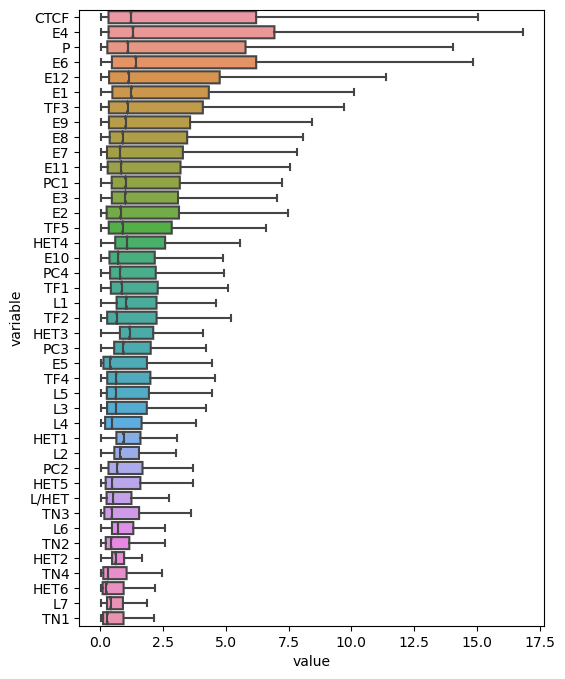

In [10]:
fig, ax = plt.subplots(figsize=(6,8))
y = "variable"
x = "value"
data=sei_melt
sns.boxplot(x=x,y=y,data=data, order=ordered_markers, showfliers =False, notch=True)
OUT = os.path.join(RE, f"reg.class.sei.pdf")
if os.path.exists(OUT) is False:
    plt.savefig(OUT,bbox_inches='tight')

# MPRA - scaled

In [11]:
mpra = pd.read_csv(MPRA, sep='\t')

mpra.head()

,name,l2.ratio.1.ctrl,l2.ratio.2.ctrl,l2.ratio.3.ctrl,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,pval,label.ctrl,label.us,response
0,SYNTHETIC:_Added_CCTTCCTG_GCCCGGGGG_TATACATA_a...,-1.734932,-1.567864,-1.754317,-1.296335,-1.276191,-1.294565,-1.734932,-1.685704,0.102512,-1.294565,-1.289030,0.011155,0.440367,0.396674,0.020518,False,False,False
1,hob_k27ac_up_chr1:67427680-67427949,-0.424418,-0.573461,-0.482278,-0.718239,-0.742376,-0.715355,-0.482278,-0.493385,0.075140,-0.718239,-0.725323,0.014838,-0.235962,-0.231938,0.029332,False,False,False
2,SYNTHETIC:_The_motif_ATTAAA_was_added_in_Pos:8...,-0.536486,-0.727045,-0.652711,-0.063230,-0.100000,-0.030887,-0.652711,-0.638747,0.096044,-0.063230,-0.064706,0.034580,0.589482,0.574042,0.004667,False,False,False
3,SYNTHETIC:_Added_TATGACTCATA_ACAGGTGTAC_ACAGGT...,0.035693,-0.341065,-0.087809,-0.984858,-1.007522,-0.870307,-0.087809,-0.131060,0.192067,-0.984858,-0.954229,0.073557,-0.897049,-0.823169,0.009918,False,False,False
4,k562_atac_up_chr15:78056378-78056647,1.793414,1.153666,1.886389,1.402855,1.376605,1.427877,1.793414,1.611156,0.398917,1.402855,1.402446,0.025639,-0.390560,-0.208711,0.460596,True,True,False


# tiles x enhancers

In [12]:
bed = pd.read_csv(TILEBED, sep='\t',)
bed.head()

print("shuffles",len(bed.loc[bed["shuf"]== True, "enh_id"].drop_duplicates()))
print("pos controls", len(bed.loc[bed["name"].str.contains("Pos"), "enh_id"].drop_duplicates()))

shuffles 204
pos controls 2


## missing MPRA + sei 

In [13]:
print("n atac/k27ac in sei:", len(set(bed["name"]).intersection(set(sei["name"]))))  # 24047 MPRA sequences missing sei data
print("n sei not in atac (synthetics):", len(set(sei["name"]).difference(set(bed["name"]))))  # 38480 sei sequences missing MPRA data

n atac/k27ac in sei: 42308
n sei not in atac (synthetics): 40119


# merged sei + MPRA

In [14]:
merged = pd.merge(mpra[["name", 'delta.med', 'delta.mean', 'l2.ratio.mean.ctrl','l2.ratio.mean.us',]], sei)
merged = pd.merge(merged, bed[['name', "enh_id", "#chr"]].drop_duplicates())
print("n tiles w/ endogenous enhancer id, MPRA activity and sei predictions",
      merged.shape[0])
print("n enhancer_ids w/ MPRA activity", len(merged["enh_id"].unique()))

n tiles w/ endogenous enhancer id, MPRA activity and sei predictions 32850
n enhancer_ids w/ MPRA activity 9826


# X and Y
x = sei predictions
y = delta activity

In [15]:
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [16]:
# params

y_cols=[ "l2.ratio.mean.ctrl", "l2.ratio.mean.us", "delta.med", "delta.mean",]
group_col = "#chr"
train_size = 0.8
data = merged
feature_matrix = merged
sei_cols = list(feature_matrix)[5:-2]


## train test split 

In [17]:
def train_test_split_Group(X, y, groups, train_size):
    """ group split for train, test
    inputs
        X - np array of features
        y - np array of predictor
        groups - np array of group labels
        train_size - float, fraction of training
    """
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
    for train_index, test_index in gss.split(X, y, groups):
        trainx, testx = X[train_index], X[test_index]

        trainy, testy = y[train_index], y[test_index]
        
        print(f"  Train: index={train_index}, group={np.unique(groups[train_index])}")
        print(f"  Test:  index={test_index}, group={np.unique(groups[test_index])}")
        print(len(set(np.unique(groups[train_index])).intersection(set(np.unique(groups[test_index])))))

    return trainx, trainy, testx, testy, train_index, test_index

In [18]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reg', LinearRegression())])

predicting l2.ratio.mean.ctrl
  Train: index=[    1     2     3 ... 32843 32845 32848], group=['chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr19' 'chr20'
 'chr22' 'chr22_KI270733v1_random' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7'
 'chr9' 'chrUn_GL000195v1' 'chrUn_GL000219v1' 'chrX' 'chrY']
  Test:  index=[    0     4    12 ... 32846 32847 32849], group=['chr1' 'chr17' 'chr18' 'chr2' 'chr21' 'chr8']
0
performance r2 0.07999776922841484 rho 0.26790768819759675
error rmse 0.8055550741538579 mae 0.6792249132115069
predicting l2.ratio.mean.us
  Train: index=[    1     2     3 ... 32843 32845 32848], group=['chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr19' 'chr20'
 'chr22' 'chr22_KI270733v1_random' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7'
 'chr9' 'chrUn_GL000195v1' 'chrUn_GL000219v1' 'chrX' 'chrY']
  Test:  index=[    0     4    12 ... 32846 32847 32849], group=['chr1' 'chr17' 'chr18' 'chr2' 'chr21' 'chr8']
0
performance r2 0.06716882736714402 rho 0.2389669788561839
error rmse

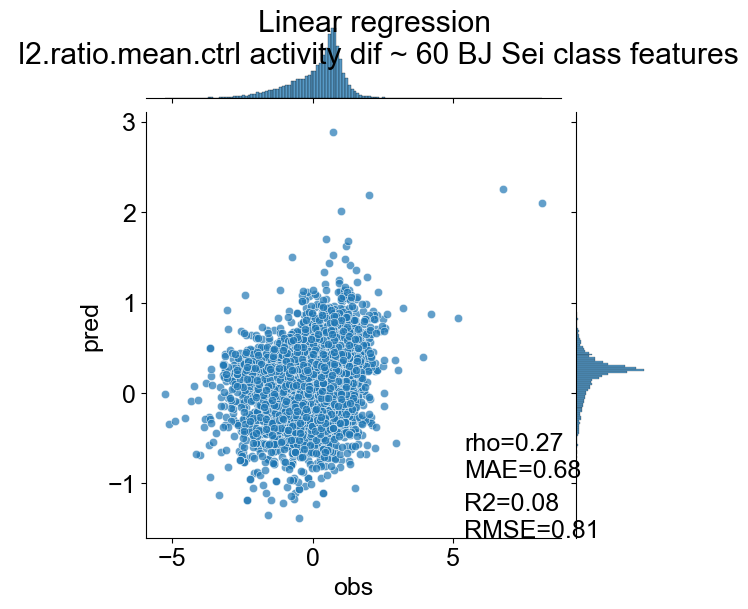

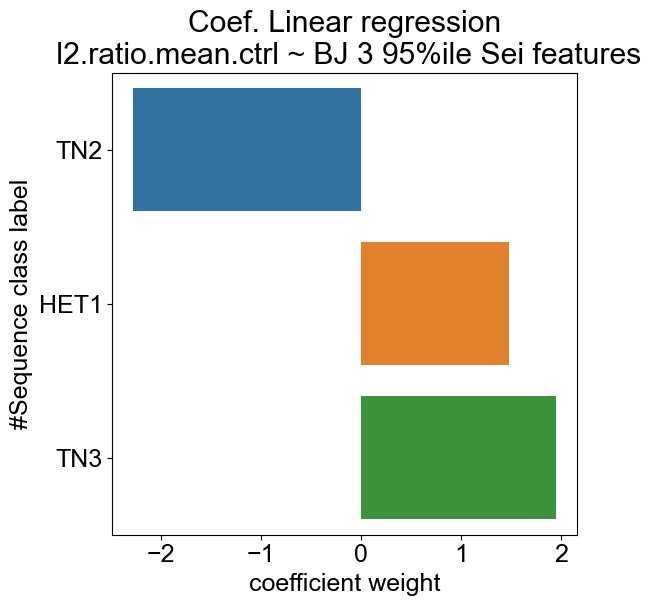

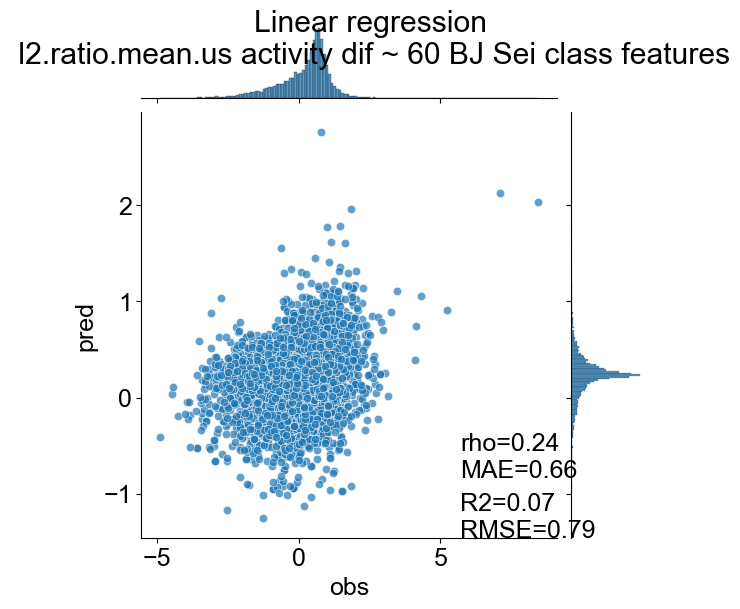

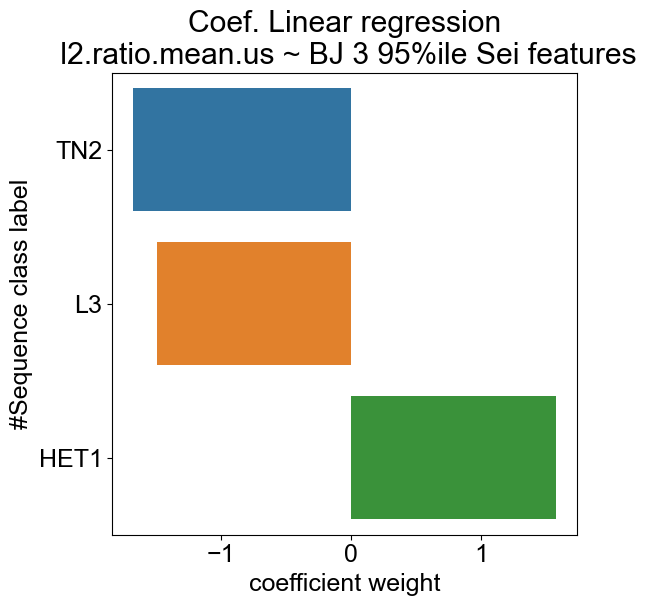

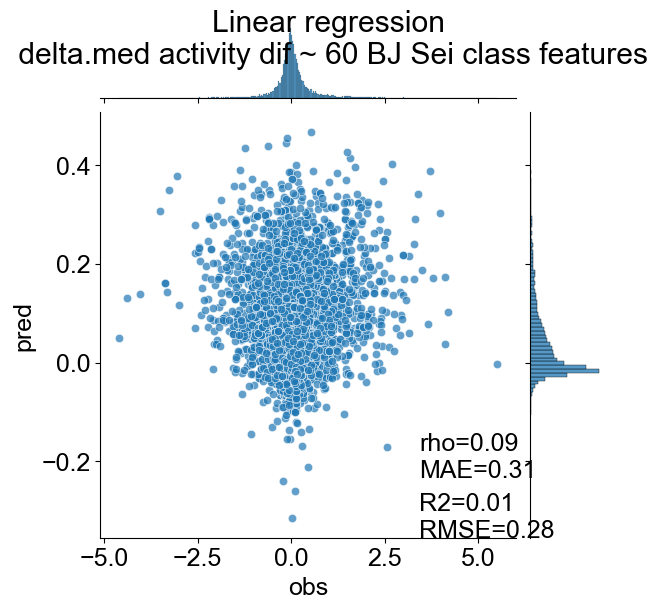

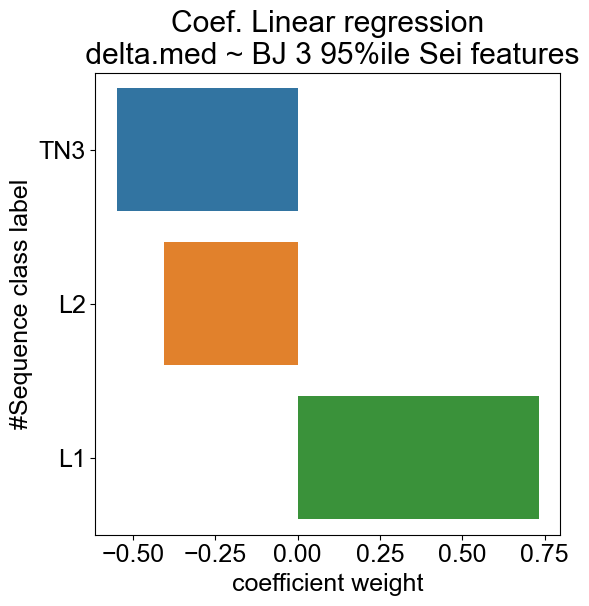

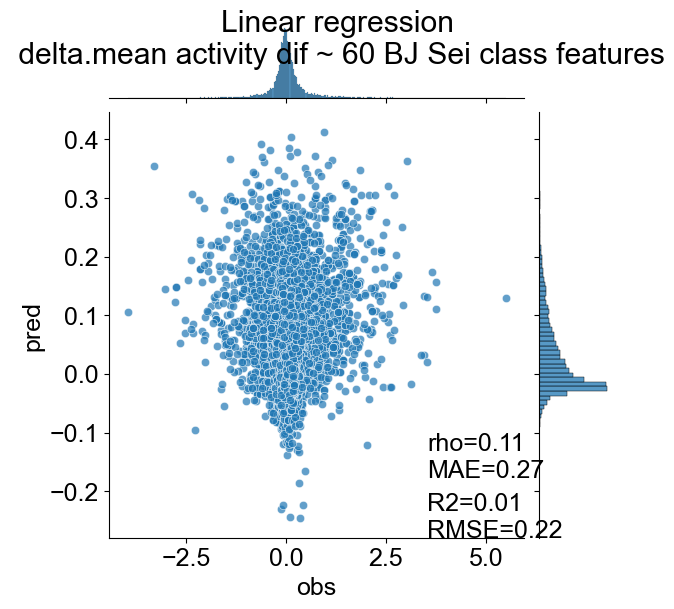

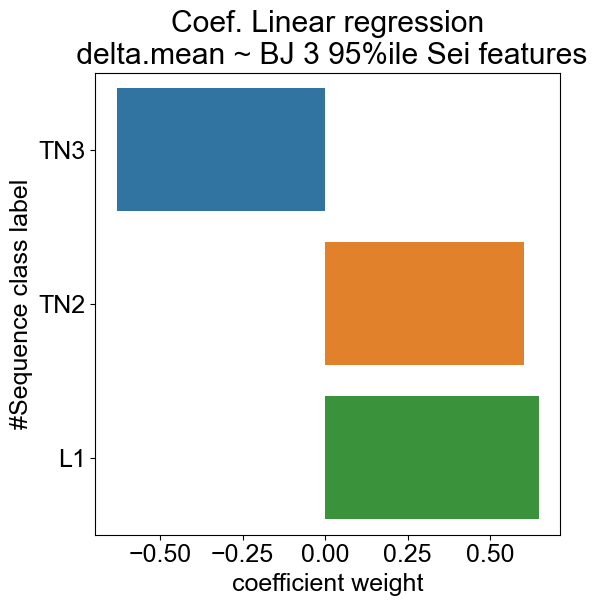

In [19]:
for y_col in y_cols:
    print("predicting", y_col)
    # set up X and Y
    group_col = "#chr"
    train_size = 0.8
    data = merged
    feature_matrix = merged
    sei_cols = list(feature_matrix)[6:-2]
    
    X = np.array(data[sei_cols])
    y = np.array(data[y_col])
    groups = np.array(data[group_col])
    
    # train test split
    trainX, trainy, testX, testy, traini, testi = train_test_split_Group(X, y, groups, train_size)
    
    # fit
    pipe.fit(trainX, trainy)

    # predict
    pred_y = pipe.predict(testX)

    ## r2, rho

    rsquared = pipe.score(testX, testy)
    rho, p = spearmanr(testy, pred_y)
    print('performance r2',  rsquared, "rho", rho)

    ## mean squared error , mean abs error (robust)

    rmse = mean_squared_error(testy, pred_y)
    mae = mean_absolute_error(testy, pred_y)
    print("error rmse", rmse, 'mae', mae)

    # PLOT
    #fig, ax= plt.subplots(figsize=(6,6))
    j = sns.jointplot(x=testy, y=pred_y, alpha=0.7)
    j.set_axis_labels('obs', 'pred')

    j.fig.suptitle(f"Linear regression\n {y_col} activity dif ~ 60 {QUERY} Sei class features")

    j.fig.text(0.65,0.1, f"R2={round(rsquared, 2)}\nRMSE={round(rmse, 2)}")
    j.fig.text(0.65,0.2, f"rho={round(rho, 2)}\nMAE={round(mae, 2)}")

    OUT = os.path.join(RE, f"reg.mpra.class.{y_col}.obs.exp.pdf")
    plt.savefig(OUT, bbox_inches="tight")

    ## coeff weights

    reg = pipe.named_steps["reg"]

    coeff = {}
    for score, col in zip(reg.coef_, sei_cols):
        coeff[col]=score

    cscores = pd.DataFrame(coeff.items())

    cscores.columns=["#Sequence class label", "score"]
    cscores = pd.merge(cscores, seqClass)
    cscores.sort_values(by="score")

    fig, ax= plt.subplots(figsize=(6,6))
    data = cscores.loc[cscores["score"].abs() >cscores["score"].abs().quantile(0.95)]
    x="score" 
    y="#Sequence class label"
    sns.barplot(x=x, y=y, data=data.sort_values(by="score"))
    ax.set(title = f"Coef. Linear regression\n {y_col} ~ {QUERY} {data.shape[0]} 95%ile Sei features",
           xlabel = "coefficient weight"
          )
    OUT = os.path.join(RE, f"reg.class.{y_col}.coef.pdf")

    plt.savefig(OUT, bbox_inches="tight")


# regularization 
- lasso - doesn't work
- ridge, gridsearchcv recommends alpha=100

In [31]:
ytrain_df= np.array(merged.iloc[traini][y_col])
xtrain_df= np.array(merged.iloc[traini][sei_cols])
groups = np.array(merged.iloc[traini][group_col])

#gridSearchModel(xtrain_df, ytrain_df, True, groups)  # gridsearch does not do stratified group split. 

In [32]:
def cv(x_, y_, groups, model_name):
    
    best_score, best_rho = 0, 0
    
    
    last_test = set()
    # shuffle split on 
    gss = GroupShuffleSplit(n_splits=10, train_size=0.9, 
                            #random_state=42
                           )
    sc = StandardScaler()
    for alpha in [0.01, 0.1,10,100, 1000]:
        print("\ntesting alpha", alpha, "\n")
        mean_score, mean_rho = [],[]
        n = 0
        for train_index, test_index in gss.split(x_, y_, groups):
        
            print("fold", n)
            n+=1
            trainx_, testx_ = x_[train_index], x_[test_index]
            trainy_, testy_ = y_[train_index], y_[test_index]

            #print(len(set(test_index).difference(last_test)))

            # update last_test
            last_test = test_index        
            
            if model_name == "Ridge":
                model = Ridge(alpha=alpha)
                
            elif model_name == "Lasso":
                model = Lasso(alpha=alpha)
            
            elif model_name =="elastic":
                model = ElasticNet(alpha=alpha)
                
            elif model_name =="linear":
                model = LinearRegression()

            # scale features
            trainx_sc, testx_sc = sc.fit_transform(trainx_), sc.fit_transform(testx_)
            
            model.fit(trainx_sc, trainy_)
            
            y_pred = model.predict(testx_sc)
            
            score = model.score(testx_sc, testy_)
            
            rho, p = spearmanr(testy_, y_pred)
            
            # pearson
            if score > best_score:
                best_score = score
            
            # rho
            if rho> best_rho:
                best_rho = rho
            
            mean_score.append(score), mean_rho.append(rho)
        print(model_name,alpha, 
              "mean score", np.mean(mean_score).round(2), 
              #"best pearson", round(best_score,2),
              "mean rho", np.mean(mean_rho).round(2), 
              #"best rho", round(best_rho,2), 
              )
        if model_name =="linear":
            # no alpha optimization
            break

In [33]:
 cv(xtrain_df, ytrain_df, groups, "linear")


testing alpha 0.01 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
linear 0.01 mean score 0.01 mean rho 0.11


In [34]:
 cv(xtrain_df, ytrain_df, groups, "Ridge")


testing alpha 0.01 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge 0.01 mean score 0.02 mean rho 0.12

testing alpha 0.1 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge 0.1 mean score 0.01 mean rho 0.1

testing alpha 10 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge 10 mean score 0.01 mean rho 0.1

testing alpha 100 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge 100 mean score 0.02 mean rho 0.11

testing alpha 1000 

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
Ridge 1000 mean score 0.01 mean rho 0.12


In [72]:
 cv(xtrain_df, ytrain_df, groups, "elastic")


testing alpha 0 

3231


/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(trainx_, trainy_)
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+03, tolerance: 4.272e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  mod

best pearson 0.0057363146724515035 0
best rho 0.093625533862871 0
3426


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e+03, tolerance: 4.123e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

best pearson 0.020121023687894368 0
best rho 0.12486570151357634 0
2666


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.266e+03, tolerance: 4.658e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3741


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e+03, tolerance: 3.983e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

best rho 0.14175374403183497 0
3985


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e+03, tolerance: 4.053e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2601


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e+03, tolerance: 4.648e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

best pearson 0.03271890362197849 0
best rho 0.14340384374948373 0
3522


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e+03, tolerance: 4.245e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

best pearson 0.037156459883481596 0
1348


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+03, tolerance: 4.315e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3119


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e+03, tolerance: 4.224e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/4036689289.py:34: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

1647


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.251e+03, tolerance: 4.617e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0) mean score 0.037156459883481596 mean rho 0.11290952462832089 0

testing alpha 10 

4045


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4188


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4132


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4430


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1590


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2309


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3381


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3685


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2938


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3269


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


ElasticNet(alpha=10) mean score 0.037156459883481596 mean rho nan 10

testing alpha 100 

3740


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3938


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3018


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2536


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3232


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1670


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1134


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3287


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1852


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2089


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


ElasticNet(alpha=100) mean score 0.037156459883481596 mean rho nan 100

testing alpha 1000 

2513


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1188


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4990


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2637


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2967


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1355


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2035


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2723


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1799


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2249
ElasticNet(alpha=1000) mean score 0.037156459883481596 mean rho nan 1000


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [68]:
 cv(xtrain_df, ytrain_df, groups, "Lasso")


testing alpha 0 

2787


/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model = Lasso(alpha=alpha).fit(trainx_, trainy_)
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+03, tolerance: 4.621e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/R

best pearson 0.028688907846209033 0
best rho 0.1531743142749414 0
3871


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e+03, tolerance: 4.134e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2637


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e+03, tolerance: 3.772e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3287


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e+03, tolerance: 4.537e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2032


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e+03, tolerance: 4.506e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2875


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e+03, tolerance: 4.457e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

1904


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e+03, tolerance: 4.443e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3401


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e+03, tolerance: 4.353e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

3225


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+03, tolerance: 4.570e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/scratch/fongsl/ipykernel_48883/1842531335.py:29: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression es

2529


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e+03, tolerance: 4.319e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0) mean score 0.028688907846209033 mean rho 0.12100106392702188 0

testing alpha 10 

2762


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2619


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1181


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1635


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1663


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


726


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3382


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1354


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2271


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4769


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Lasso(alpha=10) mean score 0.028688907846209033 mean rho nan 10

testing alpha 100 

2060


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3678


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


726


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4046


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3717


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4518


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2403


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3116


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4193


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3818


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Lasso(alpha=100) mean score 0.028688907846209033 mean rho nan 100

testing alpha 1000 

1753


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1128


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


674


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3671


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1141


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


983


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3779


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1194


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4336


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2543
Lasso(alpha=1000) mean score 0.028688907846209033 mean rho nan 1000


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [ ]:
def gridSearchModel(X_train, y_train, standard_scaler, group):
    # select alpha for lasso regression? 
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    
    # try alphas - penalty weight
    lasso_alphas = np.linspace(0, 100, 10)
    grid = dict()
    grid['alpha'] = lasso_alphas

    
    # scale data?
    if standard_scaler is True:
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        
    # run grid search
    model=Ridge()
    """
    # stratified k fold does not work when group is continuous, not binary, or multiclass
    lst_accu_stratified = []
    for alpha in [0, 100, 10]:
        print("alpha", alpha)
        
        for train_index, test_index in skf.split(X_train, y_train, group):
            x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
            y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
            model=Ridge(alpha=alpha)
            model.fit(x_train_fold, y_train_fold)
            lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
            print((model.score(x_test_fold, y_test_fold)))
    """


    search = GridSearchCV(model, grid, cv=cv).fit(X_train, y_train)

    cvres = search.cv_results_
    
    # return best scores
    print("\n\nbest params, score", search.best_params_, search.best_score_, "\n\n")
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
